<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritzKokiU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi
!pip install preliz


import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import pymc as pm
import preliz as pz

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-bao4xo02
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-bao4xo02
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=a62306a32568233bf0366b7bd8154d1f5491eca5422275f8d710b8878e2e617b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1z8ma0jc/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.6 MB/s eta 0:00:00
   ━

**Intro**

I wanted to see if students' exam scores were really influenced by common predictors like how much the student studies, how often they finish assignments, and how much they use social media.

ExamScore is out of 100, AssignmentComp is a percentage of assignments completed, SocialMedia is the amount of hours per week spent on social media, and StudyHours is hours per week spent on studying.

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/Fritz302/data-science/refs/heads/main/Student%20Data%20-%20goog4_request%26X-Goog-Date%3D20250304T192928Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D63596d0605fbfab87780650ee7a7761af5404db36dd5e4e82919f94c73d1471fddc53e55bf270459c30458d28ad5874fdc3846e6205b18626a31a.csv')
data = data[['AssignmentComp', 'ExamScore', 'SocialMedia', 'StudyHours']]
data_sampled = data.sample(n=1000, random_state=42) #random sample, cutting it down from 10000 to 1000, the 42 is so that it can be reproduced
data_sampled

,AssignmentComp,ExamScore,SocialMedia,StudyHours
6252,66,94,20,17
4684,71,46,29,8
1731,98,56,27,38
4742,61,81,13,39
4521,75,68,25,13
...,...,...,...,...
3921,63,80,22,13
6685,50,65,14,27
3194,98,90,7,26
1941,66,57,25,25


array([[<Axes: xlabel='AssignmentComp', ylabel='AssignmentComp'>,
        <Axes: xlabel='ExamScore', ylabel='AssignmentComp'>,
        <Axes: xlabel='SocialMedia', ylabel='AssignmentComp'>,
        <Axes: xlabel='StudyHours', ylabel='AssignmentComp'>],
       [<Axes: xlabel='AssignmentComp', ylabel='ExamScore'>,
        <Axes: xlabel='ExamScore', ylabel='ExamScore'>,
        <Axes: xlabel='SocialMedia', ylabel='ExamScore'>,
        <Axes: xlabel='StudyHours', ylabel='ExamScore'>],
       [<Axes: xlabel='AssignmentComp', ylabel='SocialMedia'>,
        <Axes: xlabel='ExamScore', ylabel='SocialMedia'>,
        <Axes: xlabel='SocialMedia', ylabel='SocialMedia'>,
        <Axes: xlabel='StudyHours', ylabel='SocialMedia'>],
       [<Axes: xlabel='AssignmentComp', ylabel='StudyHours'>,
        <Axes: xlabel='ExamScore', ylabel='StudyHours'>,
        <Axes: xlabel='SocialMedia', ylabel='StudyHours'>,
        <Axes: xlabel='StudyHours', ylabel='StudyHours'>]], dtype=object)

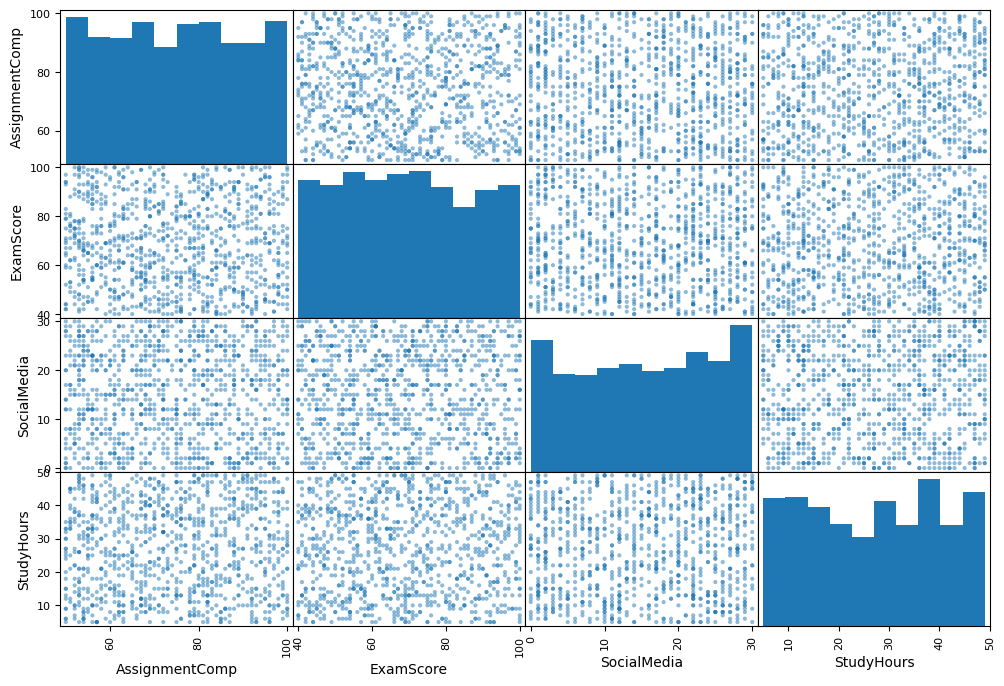

In [7]:
pd.plotting.scatter_matrix(data_sampled, figsize=(12, 8))

**B Spline**

After plotting the matrix I am not seeing any clearly linear relationships so maybe a B Spline will work.

In [14]:
study_hours_min = data['StudyHours'].min()
study_hours_max = data['StudyHours'].max()
social_media_min = data['SocialMedia'].min()
social_media_max = data['SocialMedia'].max()
assignmentcomp_min = data['AssignmentComp'].min()
assignmentcomp_max = data['AssignmentComp'].max()

In [15]:
num_knots = 6
study_knots = np.linspace(study_hours_min, study_hours_max, num_knots + 2)[1:-1]
social_knots = np.linspace(social_media_min, social_media_max, num_knots + 2)[1:-1]
assignment_knots = np.linspace(assignmentcomp_min, assignmentcomp_max, num_knots + 2)[1:-1]
model_spline = bmb.Model("ExamScore ~ bs(StudyHours, degree=3, knots=study_knots) + bs(SocialMedia, degree=3, knots=social_knots) + bs(AssignmentComp, degree=3, knots=assignment_knots)", data, family="gaussian")
idata_spline = model_spline.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


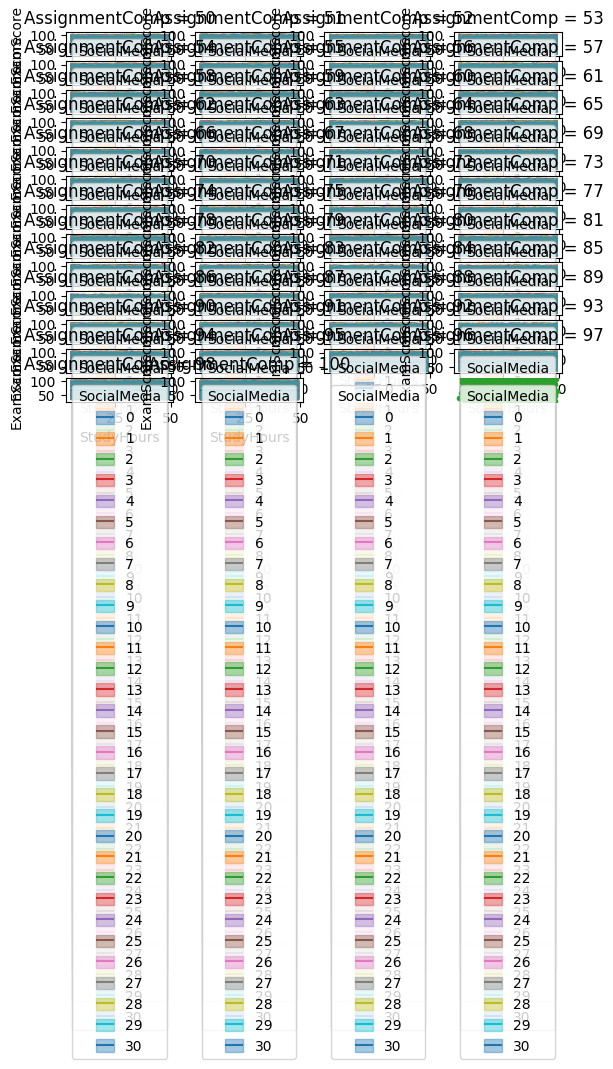

In [16]:
bmb.interpret.plot_predictions(model_spline, idata_spline, ["StudyHours", "SocialMedia", "AssignmentComp"], pps= True)
plt.plot(data.StudyHours + data.SocialMedia + data.AssignmentComp, data.ExamScore, "C2.", zorder=-3)

**Polynomial Models**

Now I'll try to see if a polynomial will fit better.

In [17]:
model_poly_2 = bmb.Model("`ExamScore` ~ poly(`SocialMedia`, degree=2)", data)
idata_poly_2 = model_poly_2.fit()

Output()

In [20]:
model_poly_4 = bmb.Model("`ExamScore` ~ poly(`SocialMedia`, degree=4)", data)
idata_poly_4 = model_poly_4.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


Text(0.5, 1.0, 'Degree 4 Polynomial Regression')

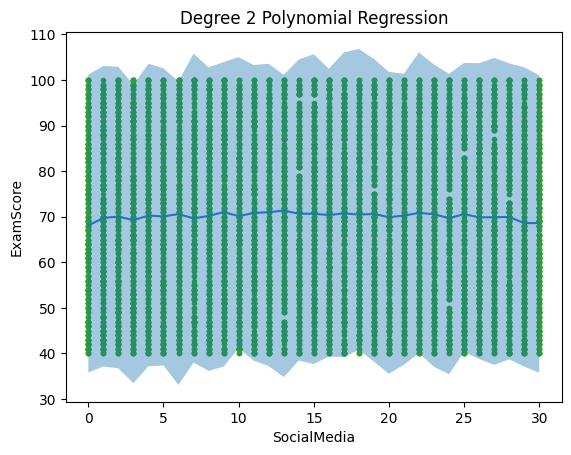

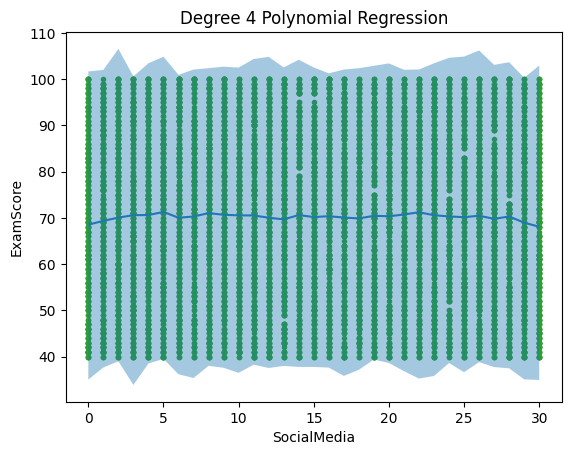

In [21]:
bmb.interpret.plot_predictions(model_poly_2, idata_poly_2, "SocialMedia", pps=True)
plt.plot(data['SocialMedia'], data['ExamScore'], "C2.", zorder=-3)
plt.title("Degree 2 Polynomial Regression")

bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "SocialMedia", pps=True)
plt.plot(data['SocialMedia'], data['ExamScore'], "C2.", zorder=-3)
plt.title("Degree 4 Polynomial Regression")

In [23]:
idata_poly_2 = model_poly_2.fit(idata_kwargs={"log_likelihood":True})
idata_poly_4 = model_poly_4.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

**Now to Compare**

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

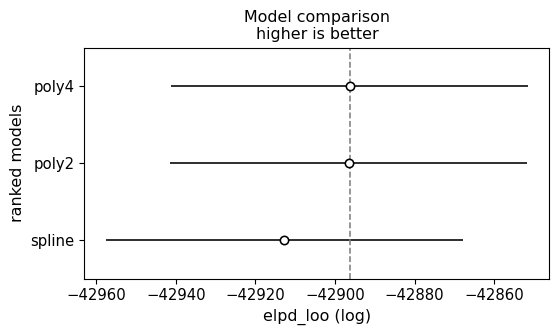

In [24]:
compare = az.compare({"spline":idata_spline, "poly2":idata_poly_2, "poly4":idata_poly_4})
az.plot_compare(compare)

**Conclusion**

The Polynomial Model did significantly better than the b spline model, with the degree not appearing to make much of a difference.

